### 0) Imports

In [5]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from joblib import dump # for performing best model
from joblib import load

### 1) Load yerevan_houses.csv dataset. The target variable is the Price (don't separate the label at first).

In [6]:
# Load
file_path = "/home/hos/Desktop/yerevan_houses.csv"
df = pd.read_csv(file_path)

### 2) Find and remove the columns that clearly don't help.

In [7]:
columns_to_drop = ["Unnamed: 0.1", "Unnamed: 0", "region", "url"]
df.drop(columns_to_drop, axis=1, inplace=True)

### 3) Find the correlations between the columns

In [8]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr(method='spearman')
print("Correlation Matrix:\n", correlation_matrix)


Correlation Matrix:
                    price  max_floor  num_rooms      area  num_bathrooms  \
price           1.000000   0.060136   0.394387  0.612235       0.390782   
max_floor       0.060136   1.000000   0.045729  0.147230       0.111190   
num_rooms       0.394387   0.045729   1.000000  0.782290       0.286139   
area            0.612235   0.147230   0.782290  1.000000       0.399076   
num_bathrooms   0.390782   0.111190   0.286139  0.399076       1.000000   
floor           0.040815   0.587390   0.041267  0.092445       0.061299   
ceiling_height  0.434639  -0.047441   0.084081  0.219667       0.259181   

                   floor  ceiling_height  
price           0.040815        0.434639  
max_floor       0.587390       -0.047441  
num_rooms       0.041267        0.084081  
area            0.092445        0.219667  
num_bathrooms   0.061299        0.259181  
floor           1.000000       -0.025624  
ceiling_height -0.025624        1.000000  


### 4) Find unique values and their counts in necessary columns.

In [9]:
unique_value_counts = {column_name: df[column_name].value_counts() for column_name in df.columns}
print("\nUnique Value Counts:\n", unique_value_counts)


Unique Value Counts:
 {'price': price
65000.0     145
60000.0     137
45000.0     134
50000.0     130
75000.0     125
           ... 
310000.0      1
51600.0       1
198900.0      1
51500.0       1
37700.0       1
Name: count, Length: 338, dtype: int64, 'condition': condition
newly repaired    3008
good              1739
zero condition     427
Name: count, dtype: int64, 'district': district
Center              2153
Arabkir             1354
Avan                 269
Davtashen            258
Nor Norq             243
Malatia-Sebastia     227
Achapnyak            210
Qanaqer-Zeytun       195
Shengavit            176
Erebuni               80
Norq Marash            5
Vahagni district       3
Nubarashen             1
Name: count, dtype: int64, 'max_floor': max_floor
5     1371
9     1040
4      519
14     472
10     316
16     276
12     209
11     166
6      163
7      136
13     109
15      86
3       69
8       61
17      51
18      45
22      16
21      16
19      15
23      14
2       14

### 5) Use plots, scatterplots, histograms, boxplots, etc. to visualize the relationships of different columns to price. (Hint: When prices are compared to categorical columns, they should be grouped by the columns' unique values (e.g. df.groupby('num_bathrooms').price.mean())).

/tmp/ipykernel_16017/88455173.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=col, y='price', data=grouped_data, palette="viridis")
/tmp/ipykernel_16017/88455173.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)


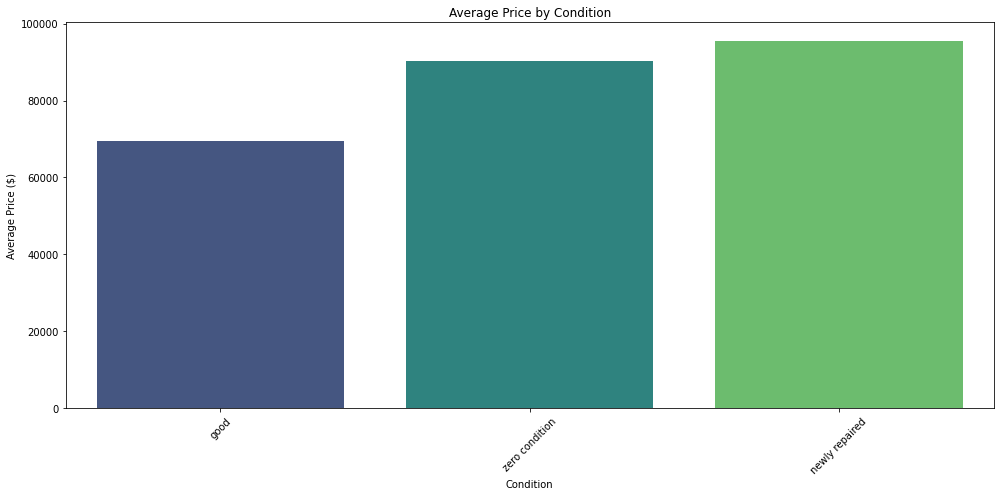

/tmp/ipykernel_16017/88455173.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=col, y='price', data=grouped_data, palette="viridis")
/tmp/ipykernel_16017/88455173.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)


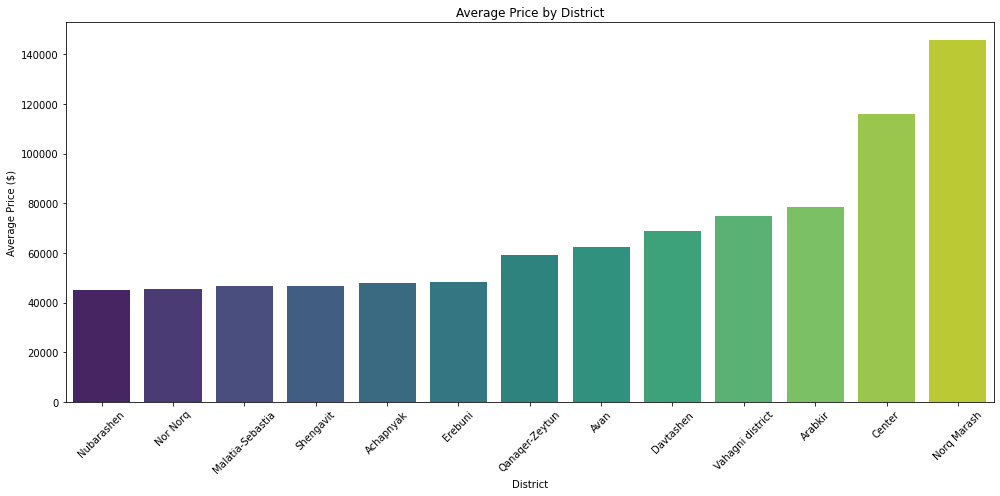

/tmp/ipykernel_16017/88455173.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=col, y='price', data=grouped_data, palette="viridis")
/tmp/ipykernel_16017/88455173.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)


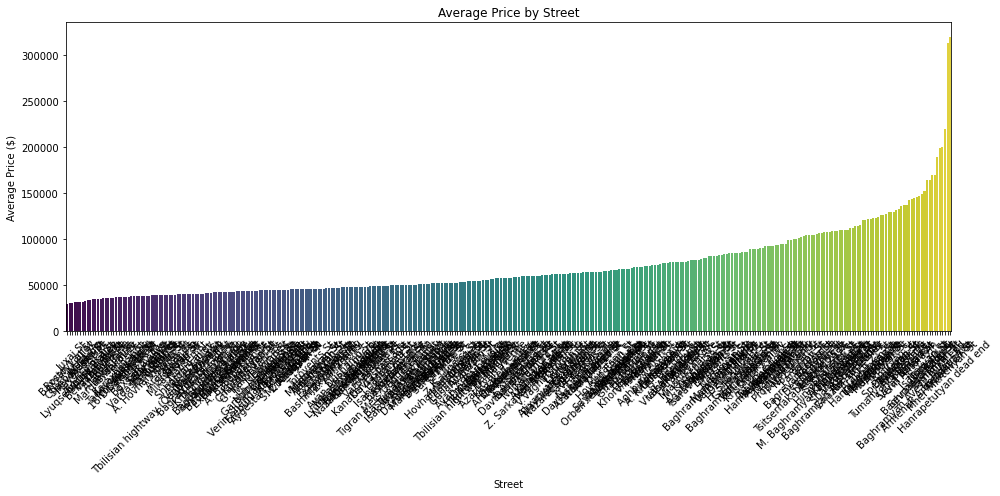

/tmp/ipykernel_16017/88455173.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=col, y='price', data=grouped_data, palette="viridis")
/tmp/ipykernel_16017/88455173.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)


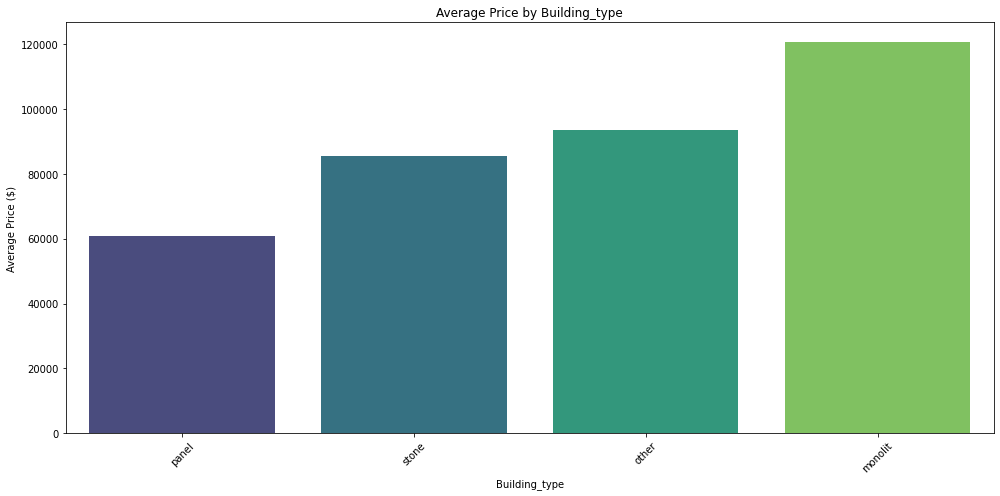

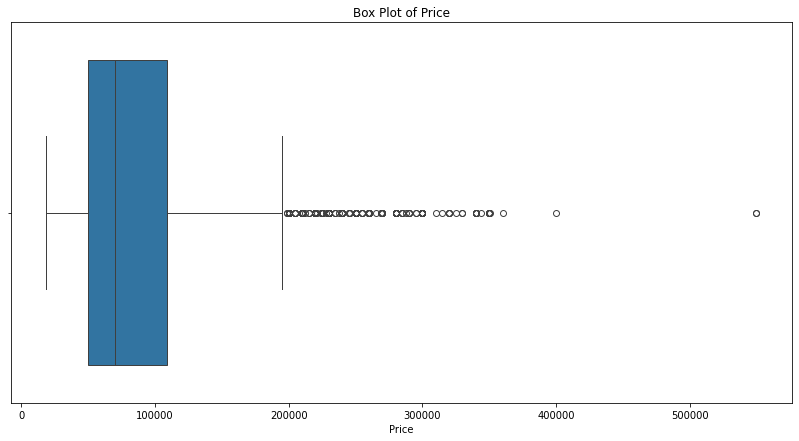

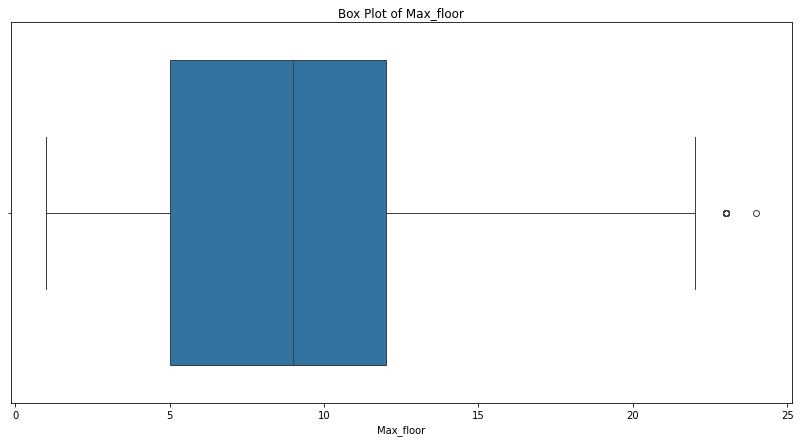

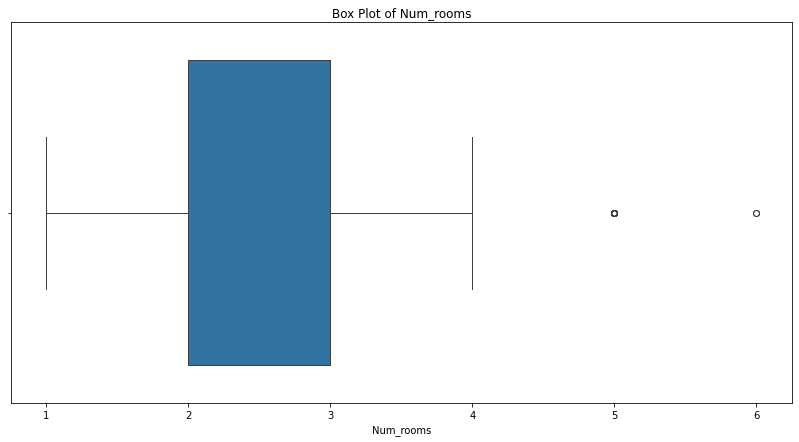

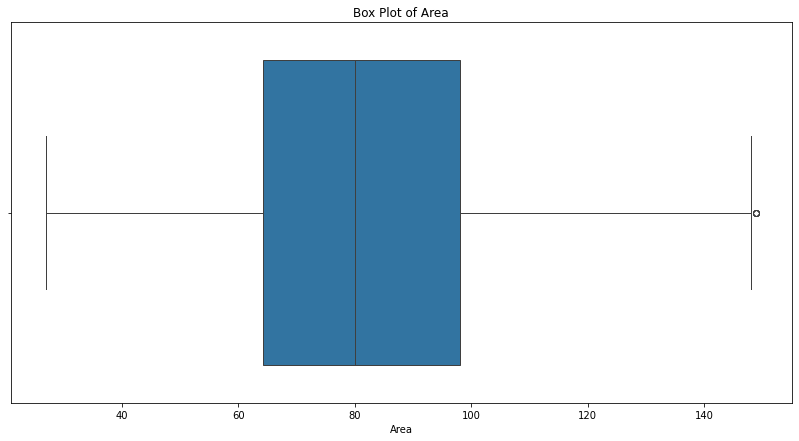

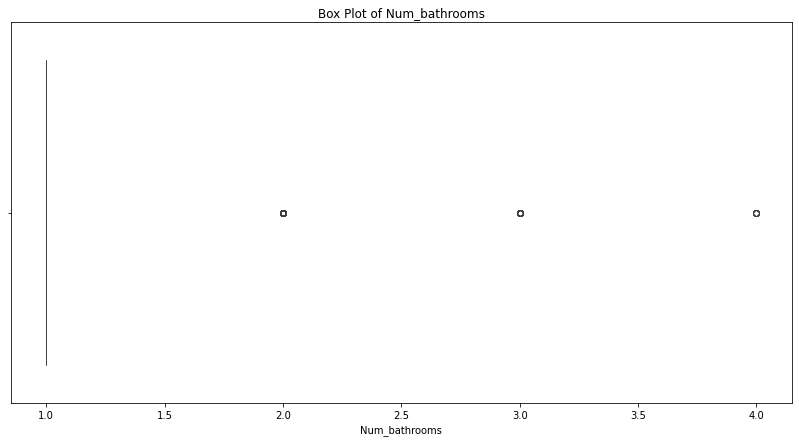

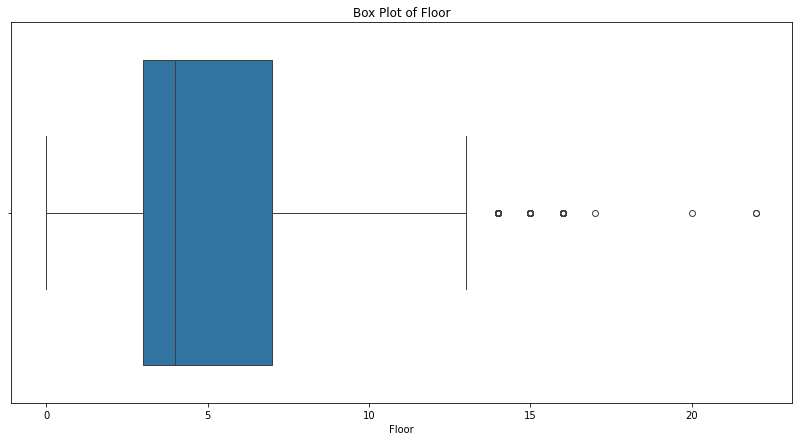

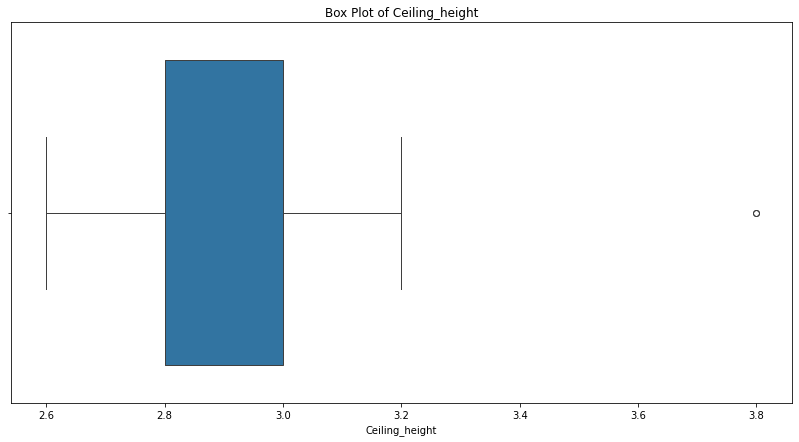

In [10]:
def plot_categorical_data(columns, dataframe):
    for col in columns:
        if dataframe[col].dtype == "object":
            grouped_data = dataframe.groupby(col)['price'].mean().sort_values().reset_index()
            plt.figure(figsize=(14, 7))
            bar_plot = sns.barplot(x=col, y='price', data=grouped_data, palette="viridis")
            bar_plot.set_title(f'Average Price by {col.capitalize()}')
            bar_plot.set_xlabel(col.capitalize())
            bar_plot.set_ylabel('Average Price ($)')
            bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)
            plt.tight_layout()
            plt.show()

def plot_numerical_boxplots(dataframe, numerical_columns):
    for col in numerical_columns:
        plt.figure(figsize=(14, 7))
        sns.boxplot(x=dataframe[col])
        plt.title(f'Box Plot of {col.capitalize()}')
        plt.xlabel(col.capitalize())
        plt.show()

categorical_columns = [col for col in df.columns
                        if df[col].dtype == "object"]
numerical_columns = [col for col in df.columns if df[col].dtype != "object"]
plot_categorical_data(categorical_columns, df)
plot_numerical_boxplots(df, numerical_columns)

### 6) Clear the data. Remove the least "correlated" columns.

In [11]:
def remove_weak_correlations(dataframe, threshold=0.1):
    for col in dataframe.select_dtypes(include=['float64', 'int64']).columns:
        if col != "price":
            correlation_coefficient, _ = pearsonr(dataframe['price'], dataframe[col])
            if abs(correlation_coefficient) <= threshold:
                dataframe.drop(col, axis=1, inplace=True)
remove_weak_correlations(df)

### 7) Find and remove the outliers

/tmp/ipykernel_16017/88455173.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=col, y='price', data=grouped_data, palette="viridis")
/tmp/ipykernel_16017/88455173.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)


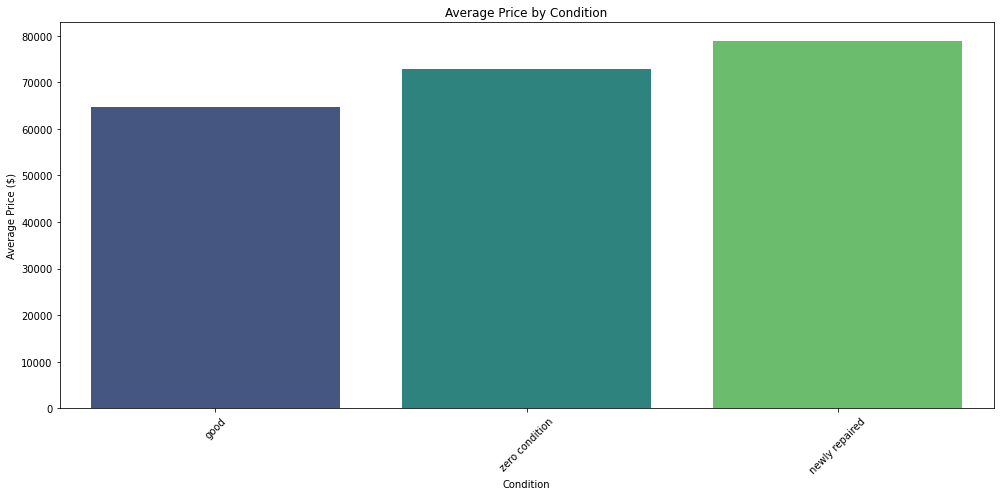

/tmp/ipykernel_16017/88455173.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=col, y='price', data=grouped_data, palette="viridis")
/tmp/ipykernel_16017/88455173.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)


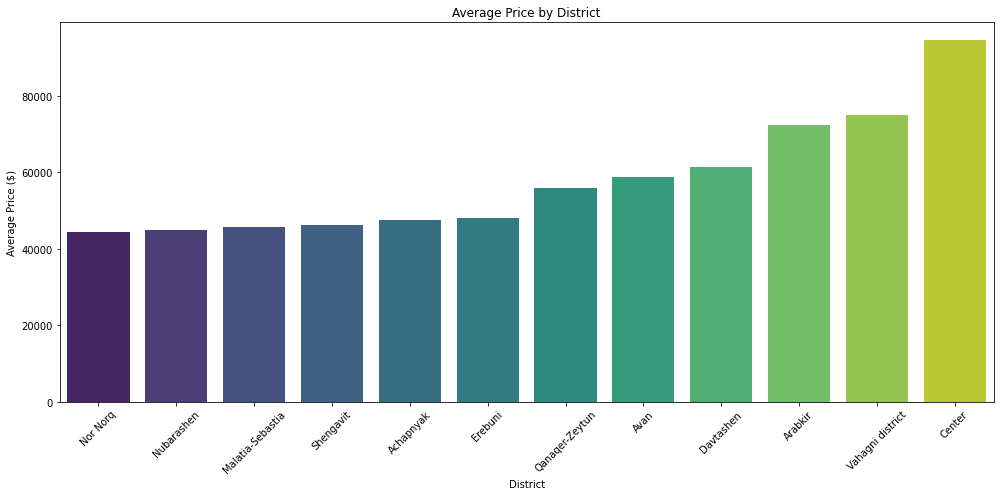

/tmp/ipykernel_16017/88455173.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=col, y='price', data=grouped_data, palette="viridis")
/tmp/ipykernel_16017/88455173.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)


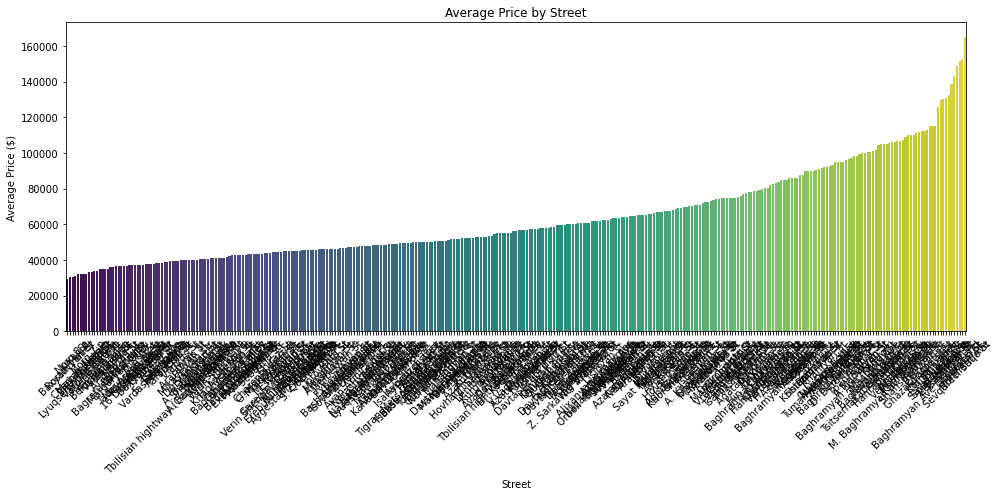

/tmp/ipykernel_16017/88455173.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=col, y='price', data=grouped_data, palette="viridis")
/tmp/ipykernel_16017/88455173.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)


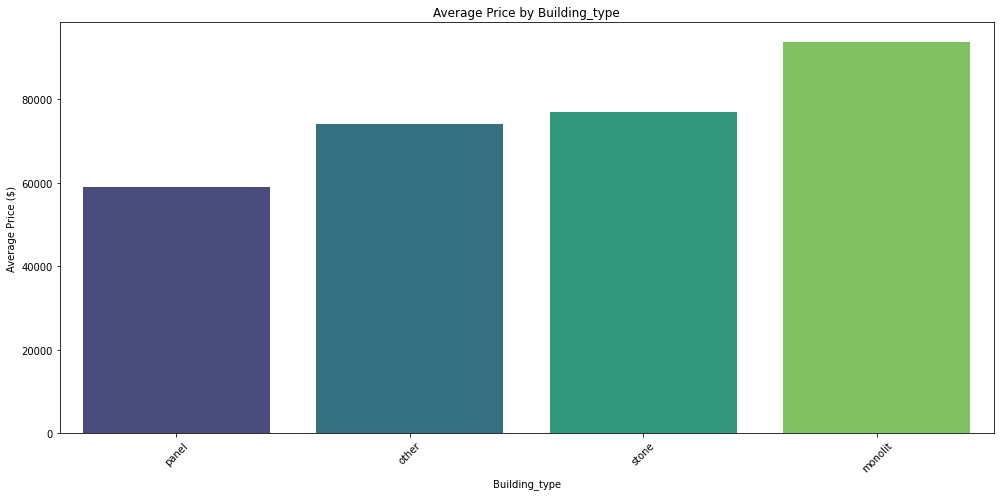

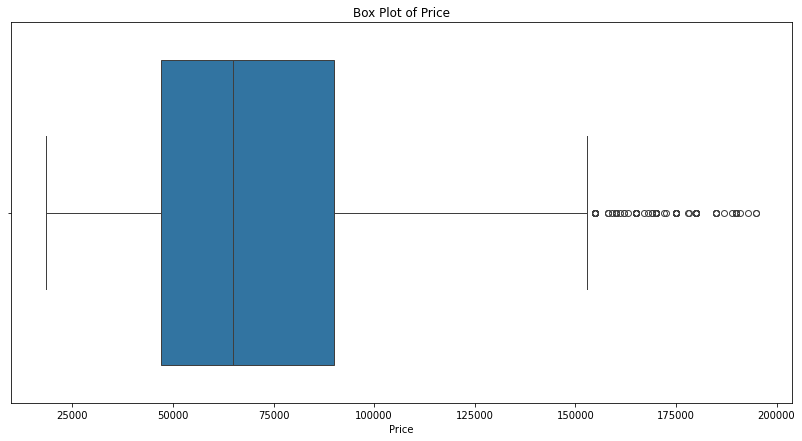

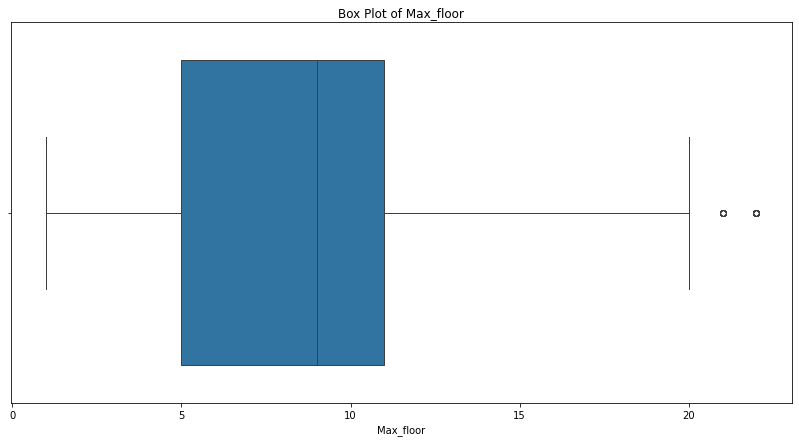

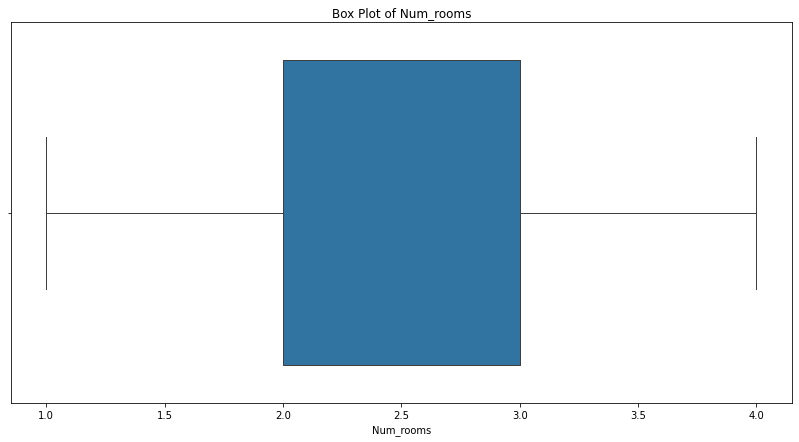

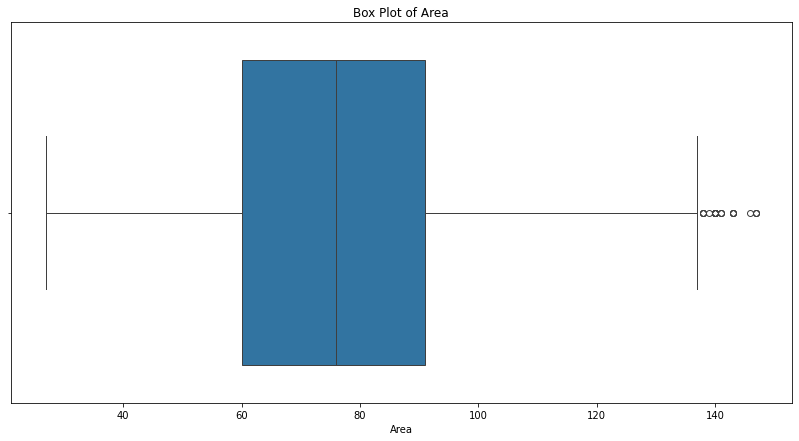

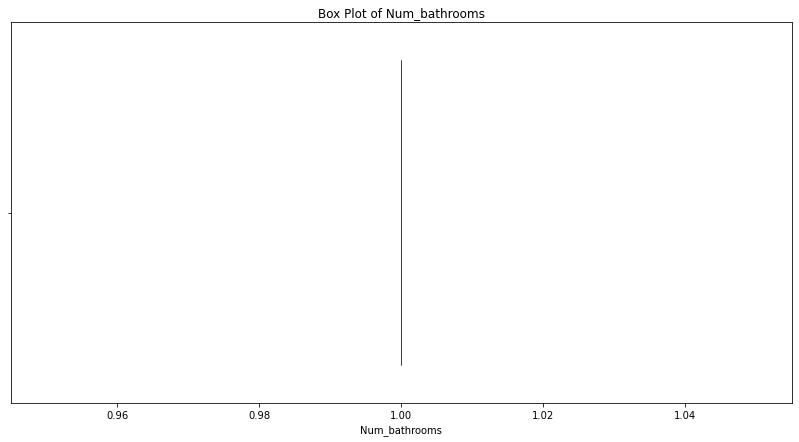

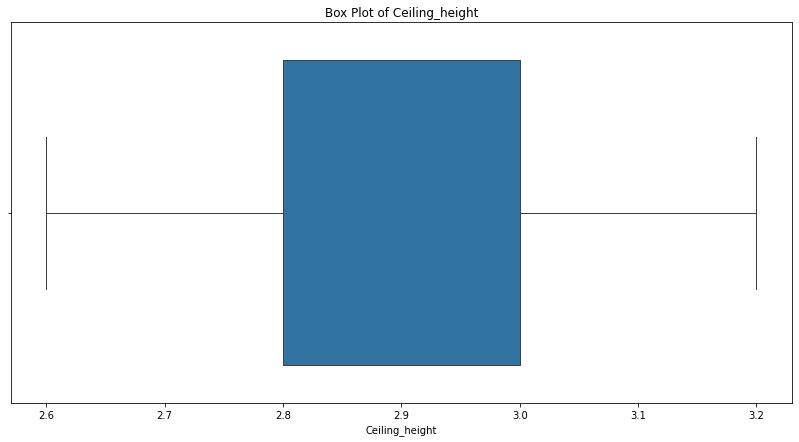

In [12]:
def remove_outliers(data, columns):
    new_data = data.copy()
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 +  1.5 * IQR
        new_data = new_data[(new_data[col] >= lower_bound) & (new_data[col] <= upper_bound)]
    return new_data

numerical_columns = [col for col in df.columns if df[col].dtype != "object"]
df = remove_outliers(df, numerical_columns)
plot_categorical_data(categorical_columns, df)
plot_numerical_boxplots(df, numerical_columns)


### 8) Separate the feature and target variables into X and y.

In [13]:
y = df['price']
x = df.select_dtypes(include=[np.number]).drop('price', axis=1)

### 9) Scale, One Hot Encode the columns (Also try to achieve overfitting by increasing the amount of features)

In [14]:
if 'condition' in df.columns:
    condition_dummies = pd.get_dummies(df['condition'], prefix='condition', drop_first=True).astype(int)
    df = pd.concat([df, condition_dummies], axis=1)
    df.drop('condition', axis=1, inplace=True)
# Min-Max scaling
def min_max_scaler(data, columns):
    for col in columns:
        if np.issubdtype(data[col].dtype, np.number) and col != "num_bathrooms": 
            min_value = data[col].min()
            max_value = data[col].max()
            data[col] = (data[col] - min_value) / (max_value - min_value)
    return data
numerical_columns = [col for col in df.columns if df[col].dtype != "object" and df[col].dtype != 'bool']
df = min_max_scaler(df, numerical_columns)

## Model

### 11) Use linear, ridge, and lasso regressions in combination with K-Fold CV to fit your training data. Calculate RMSE, MSE, MAE, and R-Squared for each split. Visualize the results.

In [15]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
metrics = {
    "Linear": {"MSE": [], "MAE": [], "R2": []},
    "Ridge": {"MSE": [], "MAE": [], "R2": []},
    "Lasso": {"MSE": [], "MAE": [], "R2": []}
}

for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for name, model in zip(["Linear", "Ridge", "Lasso"], [LinearRegression(), Ridge(alpha=1.0), Lasso(alpha=0.001)]):
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        metrics[name]["MSE"].append(mse)
        metrics[name]["MAE"].append(mae)
        metrics[name]["R2"].append(r2)

for model in metrics:
    print(f"{model} - Average MSE across folds: {np.mean(metrics[model]['MSE'])}")
    print(f"{model} - Average MAE across folds: {np.mean(metrics[model]['MAE'])}")
    print(f"{model} - Average R2 across folds: {np.mean(metrics[model]['R2'])}")
    print(f"{model} - MSE per fold: {metrics[model]['MSE']}")
    print(f"{model} - MAE per fold: {metrics[model]['MAE']}")
    print(f"{model} - R2 per fold: {metrics[model]['R2']}\n")

Linear - Average MSE across folds: 753652064.0718617
Linear - Average MAE across folds: 20923.748383539165
Linear - Average R2 across folds: 0.3634772782060982
Linear - MSE per fold: [751829048.3945173, 772965317.5867236, 749915771.3493173, 746288220.6695887, 747261962.3591622]
Linear - MAE per fold: [21143.15073996329, 21375.555638035654, 20854.951978049074, 20696.073067607595, 20549.010494040205]
Linear - R2 per fold: [0.36060632015208094, 0.3317003483231117, 0.37247018186378866, 0.39295908802879054, 0.3596504526627192]

Ridge - Average MSE across folds: 753652896.4898694
Ridge - Average MAE across folds: 20925.34158268225
Ridge - Average R2 across folds: 0.3634785314724826
Ridge - MSE per fold: [751196112.9176944, 772771678.0979092, 750125308.3995714, 746477374.0503327, 747694008.9838396]
Ridge - MAE per fold: [21139.035579251922, 21379.440428033347, 20861.767319998835, 20692.62285851388, 20553.841727613253]
Ridge - R2 per fold: [0.3611446006887219, 0.3318677674814894, 0.37229484117

### 12) After finding the best model (linear/ridge/lasso and hyperparameters) train the model on the whole data and save the weights.

In [16]:
best_model = Ridge(alpha=1.0)
best_model.fit(x, y)
dump(best_model, '/home/hos/Desktop/best_model.joblib')

coefficents = best_model.coef_
intercept = best_model.intercept_

## Testing

### 13) Load test_data.csv

In [17]:
test_file = "/home/hos/Desktop/test_data.csv"
test_df = pd.read_csv(test_file)

### 14) Preprocess the testing data using the same steps you used for training data

In [18]:
# Pay attention to scaling, one-hot encoding and other preprocessing steps that you use sklearn implementations.
# They have fit, fit_transform, and transform methods that will be required.
columns_to_drop = ["Unnamed: 0.1", "Unnamed: 0", "region", "url"]
test_df.drop(columns_to_drop, axis=1, inplace=True)

numerical_columns = [col for col in test_df.columns if test_df[col].dtype != "object"]
test_df = remove_outliers(test_df, numerical_columns)

if 'condition' in test_df.columns:
    condition_dummies = pd.get_dummies(test_df['condition'], prefix='condition', drop_first=True).astype(int)
    test_df = pd.concat([test_df, condition_dummies], axis=1)
    test_df.drop('condition', axis=1, inplace=True)

### 15) Load the saved model into a new variable and evaluate it.

In [21]:
loaded_model = load('/home/hos/Desktop/best_model.joblib')

### 16) Compare your results for training and testing sets and interprete your results.

In [23]:
for col in numerical_columns:
    if np.issubdtype(test_df[col].dtype, np.number) and col != "num_bathrooms":
        test_df[col] = (test_df[col] - test_df[col].min()) / (test_df[col].max() - test_df[col].min())

x_test = test_df.select_dtypes(include=[np.number]).drop('price', axis=1)
if 'floor' in x_test.columns:
    x_test = x_test.drop('floor', axis=1)
y_pred_test = loaded_model.predict(x_test)

test_df['predicted_price'] = y_pred_test
y_test = test_df['price']
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
rmse = math.sqrt(mse)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")